This notebook describe how the model can be used to find abnormal traffic activities

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %qtconsole

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)
			
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
import pickle
from pdpbox import pdp, info_plots

In [2]:
from datetime import datetime, timedelta 
from dateutil.relativedelta import relativedelta

# Load data and pre-process

In [3]:
url = r'data/merged_data_20190728.csv'

In [4]:
df_orig = pd.read_csv(url, parse_dates = ['count_date'])
df = df_orig.copy()
df.sort_values(by = "count_date", inplace = True)
df.head()
df.tail()

,carr_way_no,road_id,road_name,start_name,end_name,location,latest,count_date,adt,latitude,longitude,cway_width,traff_manage_level,Shape__Length
4682,12411.0,40986,COLWILL RD,SPARGO RD,END,1704.0,No,1974-07-12,125.0,-36.832191,174.636777,6.8,"< 10,000 vpd Rural/<15,000 vpd Urban",396.674078
11389,13617.0,40854,GLORIA AVE,OLD TE ATATU RD,GRAHAM AVE,99.0,No,1974-08-11,1823.0,-36.848907,174.650109,11.2,"< 10,000 vpd Rural/<15,000 vpd Urban",113.001344
65,10376.0,40798,HOBSONVILLE RD,LUCKENS RD,WESTPARK DR,1517.0,No,1974-08-11,2163.0,-36.814264,174.630139,9.0,">= 15,000 vpd Urban road, low speed",581.914617
49,10308.0,40798,HOBSONVILLE RD,MOTORWAY OVERBRIDGE (EAST ABUTMENT),OREIL AVE,158.0,No,1974-08-11,3900.0,-36.818091,174.615882,28.0,">= 15,000 vpd Urban road, low speed",199.169213
12333,11261.0,40365,TAIKATA RD,TE ATATU RD RAB,PEACHGROVE RD,30.0,No,1974-08-11,2490.0,-36.841192,174.651345,10.1,"< 10,000 vpd Rural/<15,000 vpd Urban",131.001559


,carr_way_no,road_id,road_name,start_name,end_name,location,latest,count_date,adt,latitude,longitude,cway_width,traff_manage_level,Shape__Length
22943,11585.0,40522,POMARIA RD,KINGDALE RD,LONGBURN RD,448.0,Yes,2019-03-06,6994.0,-36.861600,174.623820,8.6,"< 10,000 vpd Rural/<15,000 vpd Urban",185.273683
22964,13123.0,40909,FAIRDENE AVE,STEPHEN AVE,EDWARDS AVE,308.0,Yes,2019-03-06,3089.0,-36.865612,174.626350,7.5,"< 10,000 vpd Rural/<15,000 vpd Urban",337.605067
22942,11330.0,40389,STEPHEN AVE,POMARIA RD,KONA CRES (NORTH),107.0,Yes,2019-03-06,828.0,-36.863331,174.627693,7.0,<500 vpd (Low Volume),196.603260
22945,11747.0,40624,MILDMAY RD,HARRINGTON RD (AT TEE),LARISSA AVE,215.0,Yes,2019-03-06,294.0,-36.861519,174.617166,6.8,<500 vpd (Low Volume),175.769275
22952,12107.0,40823,HARRINGTON RD,HARRY WARD PL,ASCOT AVE,215.0,Yes,2019-03-06,1568.0,-36.859423,174.619489,7.0,"< 10,000 vpd Rural/<15,000 vpd Urban",113.234506


In [5]:
# # consider only traffic counts after 2010
# df.shape
df = df[df['count_date'] > pd.to_datetime('2009-12-31')]

In [6]:
import re
def add_datepart(df, fldname, drop=False, time=False, errors="raise"):	

    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Dayofyear', 'Week', 'Year', 'Month', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
#     , , 'Day',''Dayofweek''
#             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [7]:
# encode cat columns
from sklearn.preprocessing import LabelEncoder
cat_cols = ['carr_way_no', 'road_id', 'road_name', 'start_name', 'end_name', 
            'location', 'latest', 'traff_manage_level']
label_encoders_dict = {}
for col in cat_cols:
    new_le = LabelEncoder()
    df[col] = new_le.fit_transform(df[col])
    label_encoders_dict[col] = new_le
# one hot encode traff_manage_level
df = pd.get_dummies(df, prefix_sep = "__", columns = ['traff_manage_level'])

In [8]:
add_datepart(df, 'count_date')

# Model fitting

In [22]:
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.utils import shuffle
def split_vals(df, n):
    return df[:n].copy(), df[n:].copy()

def rmse(x,y): 
    # calculates r^2
    return math.sqrt(np.square(np.subtract(x,y)).mean())
def get_scores(m, X_train, X_valid, y_train, y_valid):
    # returns rmsq training, r^2 validation, avg accuracy training, avg accuracy validation, oob
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): 
        res.append(m.oob_score_)
    return res

def train_test_split(df, xcols, ycol, train_size_f = 0.75, shuffle_bool = False, random_state = None):
    train_size = int(df.shape[0] * train_size_f)
    if shuffle_bool:
        df_model = shuffle(df, random_state = random_state)
    else:
        df_model = df.copy()
    X, y = df_model[xcols], df_model[ycol]
    X_train, X_test = split_vals(X, train_size)
    y_train, y_test = split_vals(y, train_size)
    return X_train, X_test, y_train, y_test

def tt_split_by_years(df, xcols, ycol, train_years = [2016, 2017, 2018], test_years = [2019]):
#     train-test split by year
    df_train = df[df.count_Year.isin(train_years)]
    df_test = df[df.count_Year.isin(test_years)]
    X_train, X_test = df_train[xcols], df_test[xcols]
    y_train, y_test = df_train[ycol], df_test[ycol]
    return X_train, X_test, y_train, y_test

def split_by_forward_period(df, xcols, ycol, split_date = '2018-12-31', train_months = 36, test_months = 3):
#     walk forward train-test split
    d = pd.to_datetime(split_date)
    train_lb = d - relativedelta(months = train_months)
    test_ub = d + relativedelta(months = test_months)
    df_train = df[(df.count_date >= train_lb)&(df.count_date < d)]
    df_test = df[(df.count_date >= d)&(df.count_date < test_ub)]
    X_train, X_test = df_train[xcols], df_test[xcols]
    y_train, y_test = df_train[ycol], df_test[ycol]
    return X_train, X_test, y_train, y_test

def expanding_window_split(df, xcols, ycol, split_date = '2018-01-01', test_months = 2):
    # expanding window split
    d = pd.to_datetime(split_date)
    test_ub = d + relativedelta(months = test_months)
    df_train = df[df.count_date < d]
    df_test = df[(df.count_date >= d)&(df.count_date < test_ub)]
    X_train, X_test = df_train[xcols], df_test[xcols]
    y_train, y_test = df_train[ycol], df_test[ycol]
    return X_train, X_test, y_train, y_test

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
def plot_fi(fi): 
    # fi is a dataframe
    # plot top 10 fi: plot_fi(rf_feat_importance(m, df_trn2)[:10])
    return fi.plot('cols','imp','barh', figsize=(12,7), legend=False)

In [10]:
def get_list_of_split_dates(df, start_date = '2017-01-01', test_months = 2):
    d = pd.to_datetime(start_date)
    last_date = df.count_date.max()
    test_ub = d + relativedelta(months = test_months)
    list_of_split_dates = [d]
    while test_ub < last_date:  
        list_of_split_dates.append(test_ub)
        test_ub += relativedelta(months = test_months)
    return list_of_split_dates

def back_testing(df, xcols, ycol, list_of_split_dates, test_months = 2):
    results = []
    for split_date in list_of_split_dates:
        X_train, X_test, y_train, y_test = expanding_window_split(df, xcols, ycol, split_date = split_date, test_months = test_months)
        m.fit(X_train, y_train)
        r = get_scores(m, X_train, X_test, y_train, y_test)
        results.append(r)
    return np.vstack(results)

## Use expanding window split and 2 month forward period as the testing set

In [11]:
xcols = [col for col in df.columns]
xcols.remove('adt')
xcols.remove('road_name')
xcols.remove('count_date')
xcols.remove('latest')
ycol = 'adt'

In [12]:
m = RandomForestRegressor(n_estimators=300, max_depth=28, max_features=0.5, oob_score= True, random_state=131, n_jobs  = -1)
list_of_split_dates = get_list_of_split_dates(df, start_date =  '2018-01-01', test_months = 2)
result_df = None
for split_date in list_of_split_dates:
    X_train, X_test, y_train, y_test = expanding_window_split(df, xcols, ycol, split_date = split_date, test_months = 2)
    m.fit(X_train, y_train)
    if result_df is None:
        result_df = X_test.copy()
        result_df['adt'] = y_test
        result_df['predicted_adt'] = m.predict(X_test)
    else:
        temp_df = X_test.copy()
        temp_df['adt'] = y_test
        temp_df['predicted_adt'] = m.predict(X_test)
        result_df = pd.concat([result_df, temp_df])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=131, verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=131, verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=131, verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=131, verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=131, verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=131, verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=131, verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=28,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=True, random_state=131, verbose=0, warm_start=False)

In [13]:
result_df['rmse'] = result_df.apply(lambda row: rmse(row['adt'], row['predicted_adt']), axis = 1)

In [14]:
result_df.to_csv('data/7_result_df.csv', index = False)

In [ ]:
result_df = pd.read_csv('data/7_result_df.csv')

See if there is any association between rmse and other variables

# Model validation

## Pandas profiling

In [22]:
import pandas_profiling

In [25]:
pandas_profiling.ProfileReport(result_df)

Number of variables,32
Number of observations,2448
Total Missing (%),0.0%
Total size in memory,358.7 KiB
Average record size in memory,150.0 B
Numeric,14
Categorical,0
Boolean,9
Date,0
Text (Unique),0
Rejected,9


No obvious correlation between the explainary variables and the rmse

## Use random forest to check for potential variable interactions

In [26]:
result_df.columns

Index(['carr_way_no', 'road_id', 'start_name', 'end_name', 'location',
       'latitude', 'longitude', 'cway_width', 'Shape__Length',
       'traff_manage_level__0', 'traff_manage_level__1',
       'traff_manage_level__2', 'traff_manage_level__3',
       'traff_manage_level__4', 'traff_manage_level__5',
       'traff_manage_level__6', 'traff_manage_level__7', 'count_Dayofyear',
       'count_Week', 'count_Year', 'count_Month', 'count_Is_month_end',
       'count_Is_month_start', 'count_Is_quarter_end',
       'count_Is_quarter_start', 'count_Is_year_end', 'count_Is_year_start',
       'count_Elapsed', 'adt', 'predicted_adt', 'rmse'],
      dtype='object')

In [16]:
xcols = [col for col in result_df.columns]
for c in ['adt', 'predicted_adt', 'rmse']:
    xcols.remove(c)
ycol = 'rmse'

In [28]:
m = RandomForestRegressor(n_estimators=500, max_depth=10, max_features=0.6, oob_score= True, random_state=1, n_jobs  = 1)
X_train, X_test, y_train, y_test = train_test_split(result_df, xcols, ycol, shuffle_bool=True)
m.fit(X_train, y_train)
get_scores(m, X_train, X_test, y_train, y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=0.6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

[1260.204045421307,
 2480.554491897139,
 0.7364971735264636,
 0.23482062086070332,
 0.25448755025914294]

In [30]:
m = RandomForestRegressor(n_estimators=500, max_depth=10, max_features=0.6, oob_score= True, random_state=132, n_jobs  = 1)
X_train, X_test, y_train, y_test = train_test_split(result_df, xcols, ycol, shuffle_bool=True)
m.fit(X_train, y_train)
get_scores(m, X_train, X_test, y_train, y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=0.6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=True, random_state=132, verbose=0, warm_start=False)

[1342.2803377118635,
 2094.4469051895107,
 0.7209476181824382,
 0.350345766813678,
 0.22192791418881908]

In [29]:
m = RandomForestRegressor(n_estimators=500, max_depth=10, max_features=0.6, oob_score= True, random_state=12, n_jobs  = 1)
X_train, X_test, y_train, y_test = train_test_split(result_df, xcols, ycol, shuffle_bool=True)
m.fit(X_train, y_train)
get_scores(m, X_train, X_test, y_train, y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=0.6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=True, random_state=12, verbose=0, warm_start=False)

[1293.4378671569275,
 2479.4210695868123,
 0.7189366464050171,
 0.25258759103823636,
 0.24354400387052633]

Results varies significantly depending on the random seed, indicating poor model fit (overfitting to noise based on the random seed) and no meaningful interactions. 

Overall I would consider the rmse scores are not related to the explainatory variables but related to external factors not captured by the model e.g. the infrastructure projects taking places at Auckland.

# 10 roads with the highest rmse score

Finally, we will list out 10 roads with the highest rmse scores.

In [48]:
# add road_name, count_date back to the result_df
common_cols = ['carr_way_no', 'road_id', 'start_name', 'end_name', 'location',
       'latitude', 'longitude', 'cway_width', 'Shape__Length',
       'traff_manage_level__0', 'traff_manage_level__1',
       'traff_manage_level__2', 'traff_manage_level__3',
       'traff_manage_level__4', 'traff_manage_level__5',
       'traff_manage_level__6', 'traff_manage_level__7', 'count_Dayofyear',
       'count_Week', 'count_Year', 'count_Month', 'count_Is_month_end',
       'count_Is_month_start', 'count_Is_quarter_end',
       'count_Is_quarter_start', 'count_Is_year_end', 'count_Is_year_start',
       'count_Elapsed', 'adt']
result_df = result_df.merge(df, how = 'left', on = common_cols)

In [51]:
result_df.drop_duplicates(subset=common_cols, keep = 'first', inplace = True)

In [52]:
result_df_top10 = result_df.sort_values(by = 'rmse', ascending = False).head(10)

display_all(result_df_top10)

,carr_way_no,road_id,start_name,end_name,location,latitude,longitude,cway_width,Shape__Length,traff_manage_level__0,traff_manage_level__1,traff_manage_level__2,traff_manage_level__3,traff_manage_level__4,traff_manage_level__5,traff_manage_level__6,traff_manage_level__7,count_Dayofyear,count_Week,count_Year,count_Month,count_Is_month_end,count_Is_month_start,count_Is_quarter_end,count_Is_quarter_start,count_Is_year_end,count_Is_year_start,count_Elapsed,adt,predicted_adt,rmse,road_name,latest,count_date
1341,3817,1663,293,92,0,-36.851719,174.774587,16.6,221.290516,0,0,0,1,0,0,0,0,183,27,2018,7,False,False,False,False,False,False,1530489600,38994.0,15600.351667,23393.648333,3093,1,2018-07-02
1046,1451,3408,4005,4298,3536,-36.622511,174.668720,16.8,348.468457,0,0,1,0,0,0,0,0,143,21,2018,5,False,False,False,False,False,False,1527033600,37887.0,15770.390000,22116.610000,1283,1,2018-05-23
1049,1450,680,6,4446,3583,-36.620886,174.674041,7.0,130.462772,0,0,1,0,0,0,0,0,143,21,2018,5,False,False,False,False,False,False,1527033600,42944.0,20859.626667,22084.373333,1284,0,2018-05-23
1906,3181,1276,3167,193,1189,-36.897722,174.684289,13.0,358.787012,0,0,1,0,0,0,0,0,256,37,2018,9,False,False,False,False,False,False,1536796800,9857.0,31630.793333,21773.793333,164,1,2018-09-13
1251,2514,1180,3420,309,848,-36.795980,174.767909,8.2,155.592143,0,0,1,0,0,0,0,0,169,25,2018,6,False,False,False,False,False,False,1529280000,33997.0,12293.780000,21703.220000,878,1,2018-06-18
901,5668,3416,2351,2867,467,-36.888182,174.798299,8.0,159.720069,0,0,1,0,0,0,0,0,130,19,2018,5,False,False,False,False,False,False,1525910400,40359.0,18675.333333,21683.666667,1145,1,2018-05-10
1315,5089,2846,4055,1560,2273,-36.906562,174.888205,11.8,131.024260,0,0,1,0,0,0,0,0,178,26,2018,6,False,False,False,False,False,False,1530057600,1783.0,22833.253889,21050.253889,2259,1,2018-06-27
1331,5955,3423,1306,1964,723,-36.908490,174.883741,11.8,201.279258,0,0,1,0,0,0,0,0,178,26,2018,6,False,False,False,False,False,False,1530057600,1002.0,21567.660000,20565.660000,2260,1,2018-06-27
1968,3649,3415,2351,2805,1294,-36.889468,174.796152,12.0,171.200151,0,0,1,0,0,0,0,0,260,38,2018,9,False,False,False,False,False,False,1537142400,39395.0,19037.706667,20357.293333,1142,1,2018-09-17
1319,5956,3423,1342,1522,415,-36.906562,174.888205,10.8,424.304741,0,0,1,0,0,0,0,0,178,26,2018,6,False,False,False,False,False,False,1530057600,419.0,20491.356667,20072.356667,2260,1,2018-06-27


9 out of the 10 roads belongs to traff_manage_level__2, let's look at how traff_manage_level__2 relates to rmse

In [53]:
import seaborn as sns

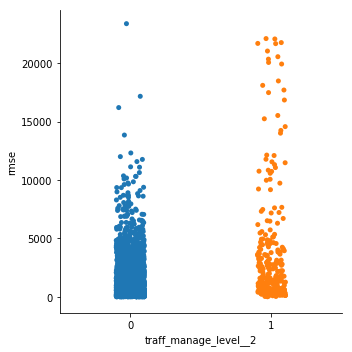

In [54]:
sns.catplot(x = 'traff_manage_level__2', y = 'rmse', data = result_df)

Most of the rmse values for samples with "traff_manage_level__2 == 0" are less than 10000 whereas there are many more samples with rmse values higher than 10000 for "traff_manage_level__2 == 1". It could be interesting to for the reasons behind this observation but unfortunately I don't have enough domain knowledge to explain this observation.

Finally I will list out 10 roads with the highest rmse.

In [64]:
# label_encoders_dict = {road_name}
result_df_top10['road_name_decode'] = result_df_top10.apply(lambda row: label_encoders_dict['road_name'].inverse_transform([row['road_name']]), axis = 1)
result_df_top10[['road_name_decode', 'count_date']]

,road_name_decode,count_date
1341,[STANLEY ST (SH 16)],2018-07-02
1046,[HIBISCUS COAST HWAY],2018-05-23
1049,[HIBISCUS COAST HWAY (SDALE - NTHBND)],2018-05-23
1906,[ASH ST],2018-09-13
1251,[ESMONDE RD DEC (EAST)],2018-06-18
901,[GREEN LANE EAST (EASTBOUND) (CWCE)],2018-05-10
1315,[PAKURANGA RD (EAST BOUND)],2018-06-27
1331,[PAKURANGA RD (WEST BOUND)],2018-06-27
1968,[GREEN LANE EAST (CWC)],2018-09-17
1319,[PAKURANGA RD (WEST BOUND)],2018-06-27
